# Lab 5
Lucas Street, 1874989

In [4]:
%%capture
import sys
!{sys.executable} -m pip install --user scipy numpy matplotlib pandas pyuvdata
from multiprocessing import Pool

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=22)
matplotlib.rc('figure', figsize=(18, 10))

import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
from pyuvdata import UVData

In [267]:
filename = 'zen.2458108.57290.HH.uvh5'
uv = UVData()
uv.read(filename, read_data=False)
unique_times = np.unique(uv.time_array)

selected_times = unique_times[0]
frequency_channels = np.arange(0, 512)
uv.read(filename, times=selected_times, freq_chans=frequency_channels)
print(sorted(uv.antenna_numbers))
print(len(uv.get_antpairs()))

[0, 1, 2, 11, 12, 13, 14, 23, 24, 25, 26, 27, 36, 37, 38, 39, 40, 41, 50, 51, 52, 53, 54, 55, 65, 66, 67, 68, 69, 70, 71, 82, 83, 84, 85, 86, 87, 88, 98, 120, 121, 122, 123, 124, 136, 137, 138, 139, 140, 141, 142, 143]
1378


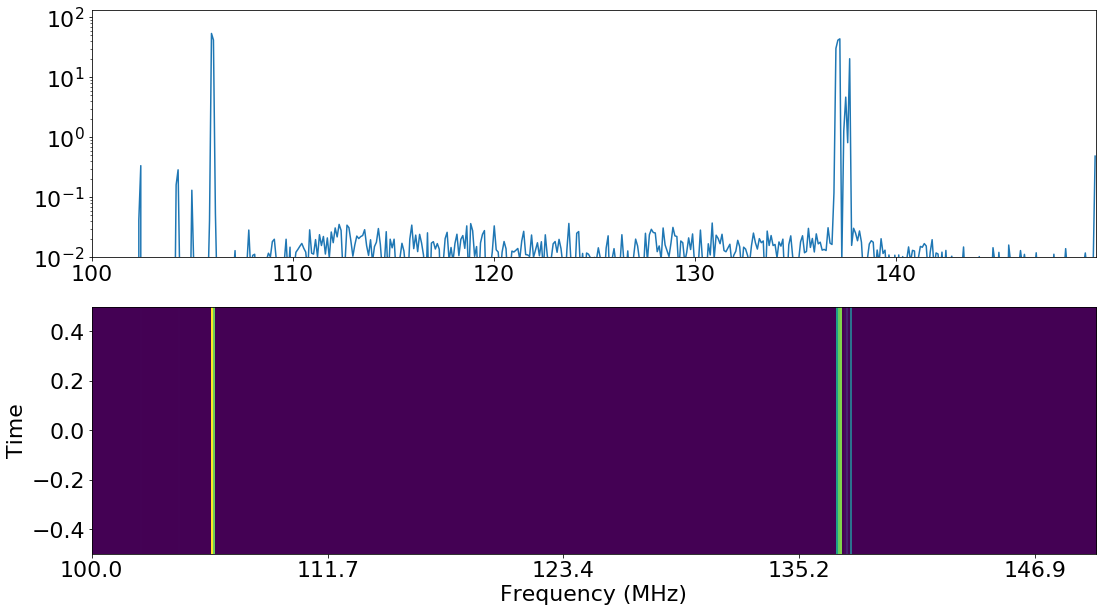

In [289]:
data = uv.get_data(25, 71, 'XY')
selected_freqs = uv.freq_array.flatten() / 1e6
total_freq_amplitudes = np.sum(np.abs(data), axis=0).flatten()

plt.subplot(2, 1, 1)
plt.plot(selected_freqs, total_freq_amplitudes)
plt.xlim(freqs[frequency_channels[0]], freqs[frequency_channels[-1]])
plt.yscale('log')
plt.ylim(1e-2, None)
plt.subplot(2, 1, 2)
plt.imshow(np.abs(data), origin='bottom', aspect='auto')
plt.xlim(0, len(frequency_channels) - 1)

# TODO: Find a way to match the same ticks as above plot
plt.xticks(np.arange(0, len(frequency_channels))[::120], selected_freqs[::120].round(1))
# plt.colorbar()
plt.ylabel('Time')
plt.xlabel('Frequency (MHz)');